# Best Model Visualization

After determining our best performing model, XGBoost Model 1, we needed to construct additional visualizations.  This notebook is primarily used for facilitation those data story visualizations. 

#### 1. [Installation and Importing of Libraries](#import)
#### 2. [XGBoost](#xgboost)


### <a name="import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries. The first cell installs packages necessary for Boruta.

In [1]:
!pip install --upgrade scikit-learn
!pip install cmake
!pip install xgboost

In [3]:
!pip install seaborn --upgrade

In [4]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sklearn
import xgboost as xgb
import lightgbm as lgb
import joblib
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score,\
classification_report, auc, recall_score, roc_curve, precision_score, precision_recall_curve, roc_auc_score, f1_score

In [5]:
print(sklearn.__version__)

1.0.2


In [6]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
def plot_roc_and_prc(y_test, y_pred_proc):
    fpr,tpr,_ = roc_curve(y_test, y_pred_proc)
    precision,recall,thresholds = precision_recall_curve(y_test, y_pred_proc)
    
    
    auc = roc_auc_score(y_test, y_pred_proc)
    
    ap = average_precision_score(y_test, y_pred_proc)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    
    
    ##plot ROC
    ax1.plot(fpr,tpr)
    ax1.plot([0,1],[0,1], "k-", color = "r",lw=1)
    ax1.annotate(f"AUC: {auc:.2f}",(.75,.25),weight="bold",size=14)
    ax1.set_ylabel('True Positive Rate/ Recall')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_title("ROC Curve")
    
    ##plot Precision-Recall Curve
    ax2.plot(recall,precision)
    ax2.set_ylabel("Precision")
    ax2.set_xlabel("Recall")
    ax2.set_title("Precision-Recall Curve")
    ax2.annotate(f"AP: {ap:.2f}",(.5,.75),weight="bold",size=14)
    
    plt.show()

In [8]:
def optimizedf1(y_test, y_pred_prob, target_recall_min = 0.0, target_recall_max = 1.0):

    
    precision,recall,threshold = precision_recall_curve(y_test, y_pred_prob,pos_label=1)
    
    fscore = np.nan_to_num((2 * precision * recall)\
                           / (precision + recall))
    
    precision_recall_table = {"precision": precision[:-1], "recall":recall[:-1],"threshold":threshold, "fscore":fscore[:-1]}
    precision_recall_table = pd.DataFrame(precision_recall_table)
    
    precision_recall_table = precision_recall_table[(precision_recall_table.recall > target_recall_min) & \
                                                   (precision_recall_table.recall < target_recall_max)].reset_index()
    
    
    
    index = np.argmax(precision_recall_table.fscore.values)
    
    return precision_recall_table.threshold[index]

In [9]:
def makeConfusionMatrixandScore(model, y_actual, X_set, thresh=0.5, labels=['No Fracture', 'Fracture']):
    ###A function for printing out a confusion matric and classification report
    ###to consistantly evaluate model performance
    if str(type(model)) == "<class 'xgboost.core.Booster'>":
        X_set =  xgb.DMatrix(X_set)
    
    y_pred_prob = model.predict(X_set)
    y_pred = pd.Series(y_pred_prob).apply(lambda x: 1 if x >= thresh else 0)
    
    cm = confusion_matrix(y_actual, np.round(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()    
    
    print(classification_report(y_actual, y_pred, target_names=labels))

In [12]:
file_path = "/dsa/groups/casestudy2023su/team03/Data4/"

X_test = pd.read_csv(file_path + "X_test.csv")
y_test = pd.read_csv(file_path + "y_test.csv")

### <a name="xgboost"></a>XGBoost

In [10]:
#bst = b4 optuna and best_model = after optuna
bst_loaded = xgb.Booster()
bst_loaded.load_model('/dsa/groups/casestudy2023su/team03/model_data/pickeled_models/XGb4optuna.json')

best_model_loaded = xgb.Booster()
best_model_loaded.load_model('/dsa/groups/casestudy2023su/team03/model_data/pickeled_models/XGoptuna.json')


In [13]:
# Convert test data to DMatrix
dtest = xgb.DMatrix(X_test)

# Predict
bst_preds = bst_loaded.predict(dtest)
best_model_preds = best_model_loaded.predict(dtest)

bst_preds_binary = (bst_preds > 0.5).astype(int)
best_model_preds_binary = (best_model_preds > 0.5).astype(int)

bst_accuracy = accuracy_score(y_test, bst_preds_binary)
best_model_accuracy = accuracy_score(y_test, best_model_preds_binary)

print("Accuracy for bst model: ", bst_accuracy)
print("Accuracy for best_model: ", best_model_accuracy)

# Calculate AUC for the bst model
bst_auc = roc_auc_score(y_test, bst_preds)
print("AUC for bst model: ", bst_auc)

# Calculate AUC for the best_model
best_model_auc = roc_auc_score(y_test, best_model_preds)
print("AUC for best_model: ", best_model_auc)


Accuracy for bst model:  0.7796327212020033
Accuracy for best_model:  0.7712854757929883
AUC for bst model:  0.6194267515923566
AUC for best_model:  0.6152634023354564


In [14]:
# classification report for b4 optuna
bst_classification_report = classification_report(y_test, bst_preds_binary)
print("Classification report for XG before optuna: ")
print(bst_classification_report)

# classification report for optuna
best_model_classification_report = classification_report(y_test, best_model_preds_binary)
print("Classification report for XG after optuna: ")
print(best_model_classification_report)


Classification report for XG before optuna: 
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       471
           1       0.41      0.07      0.12       128

    accuracy                           0.78       599
   macro avg       0.60      0.52      0.50       599
weighted avg       0.71      0.78      0.71       599

Classification report for XG after optuna: 
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       471
           1       0.32      0.06      0.10       128

    accuracy                           0.77       599
   macro avg       0.56      0.51      0.49       599
weighted avg       0.69      0.77      0.71       599



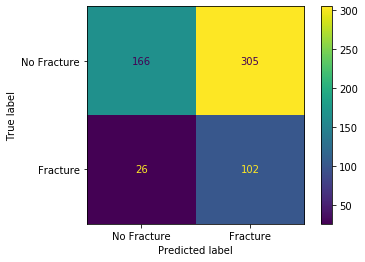

              precision    recall  f1-score   support

 No Fracture       0.86      0.35      0.50       471
    Fracture       0.25      0.80      0.38       128

    accuracy                           0.45       599
   macro avg       0.56      0.57      0.44       599
weighted avg       0.73      0.45      0.48       599



In [15]:
y_test_prob_best_model = best_model_loaded.predict(dtest)
thresh = optimizedf1(y_test, y_test_prob_best_model, 0.78, 0.9)
makeConfusionMatrixandScore(best_model_loaded, y_test, X_test, thresh)

In [15]:
#build a function for threshold categorization
def categorize_risk(probability, low_risk_threshold, medium_risk_threshold):
    if probability <= low_risk_threshold:
        return 'low'
    elif probability <= medium_risk_threshold:
        return 'medium'
    else:
        return 'high'

# Define thresholds
low_risk_threshold = 0.2
medium_risk_threshold = 0.6

y_test_flat = y_test.values.ravel()

# Use your function to categorize the risks
risk_categories = [categorize_risk(p, low_risk_threshold, medium_risk_threshold) for p in y_test_prob_best_model]

# Create a DataFrame for evaluation
df_evaluation = pd.DataFrame({'RiskCategory': risk_categories, 'ActualOutcome': y_test_flat})

# Calculate mean and sum of ActualOutcome within each RiskCategory
mean_outcomes = df_evaluation.groupby('RiskCategory')['ActualOutcome'].mean()
sum_outcomes = df_evaluation.groupby('RiskCategory')['ActualOutcome'].sum()

# Print outcomes
print(mean_outcomes)
print(sum_outcomes)



RiskCategory
high      0.454545
low       0.134831
medium    0.271028
Name: ActualOutcome, dtype: float64
RiskCategory
high       5
low       36
medium    87
Name: ActualOutcome, dtype: int64


In [45]:
# Define data
data = {
    "Precision": [0.87, 0.26, 0.74],
    "Recall": [0.37, 0.80, 0.46],
    "F1-Score": [0.52, 0.39, 0.49],
    "Support": [471, 128, 599]
}

# Create DataFrame and index
df_metrics = pd.DataFrame(data, index=["0", "1", "Weighted avg"])

# Display DataFrame
print(df_metrics)


              Precision  Recall  F1-Score  Support
0                  0.87    0.37      0.52      471
1                  0.26    0.80      0.39      128
Weighted avg       0.74    0.46      0.49      599


In [46]:
# Rename index
df_metrics = df_metrics.rename(index={'0': 'No Fracture', '1': 'Fracture'})

# Create a table using the DataFrame
fig = go.Figure(data=[go.Table(
    header=dict(values=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'],
                fill_color='lightgrey',
                align='left'),
    cells=dict(values=[df_metrics.index, df_metrics.Precision, df_metrics.Recall, df_metrics['F1-Score'], df_metrics.Support],
               fill_color='lightblue',
               align='left'))
])

fig.show()





In [17]:
# Define data
data = {
    "Mean Outcomes": [0.454545, 0.134831, 0.271028],
    "Sum Outcomes": [5, 36, 87]
}

# Create DataFrame and index
df_risk = pd.DataFrame(data, index=["High", "Low", "Medium"])

# Display DataFrame
print(df_risk)


        Mean Outcomes  Sum Outcomes
High         0.454545             5
Low          0.134831            36
Medium       0.271028            87


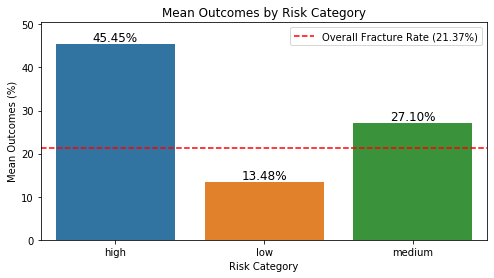

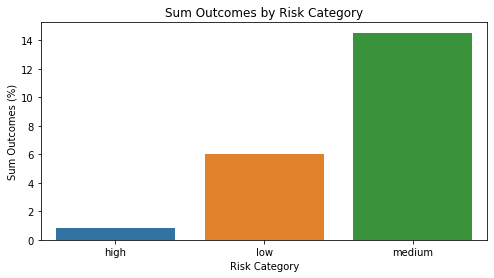

In [28]:
# calculate the percent of fractures
frac_frac = sum(y_test_flat) / len(y_test_flat) * 100

# convert the mean and sum outcomes to percentages
mean_outcomes_percent = mean_outcomes * 100
sum_outcomes_percent = sum_outcomes / len(y_test_flat) * 100

# Mean Outcomes barplot
plt.figure(figsize=(8, 4))
barplot1 = sns.barplot(x=mean_outcomes_percent.index, y=mean_outcomes_percent.values)
for p in barplot1.patches:
    barplot1.text(p.get_x() + p.get_width() / 2., p.get_height(), '{0:.2f}%'.format(p.get_height()), 
                  fontsize=12, color='black', ha='center', va='bottom')
plt.axhline(frac_frac, color='r', linestyle='--', label=f'Overall Fracture Rate ({frac_frac:.2f}%)')
plt.title("Mean Outcomes by Risk Category")
plt.xlabel("Risk Category")
plt.ylabel("Mean Outcomes (%)")
plt.ylim(0, mean_outcomes_percent.max() + 5)  # adjust the upper limit of y-axis
plt.legend()
plt.show()

# Sum Outcomes barplot
plt.figure(figsize=(8, 4))
sns.barplot(x=sum_outcomes_percent.index, y=sum_outcomes_percent.values)
plt.title("Sum Outcomes by Risk Category")
plt.xlabel("Risk Category")
plt.ylabel("Sum Outcomes (%)")
plt.show()



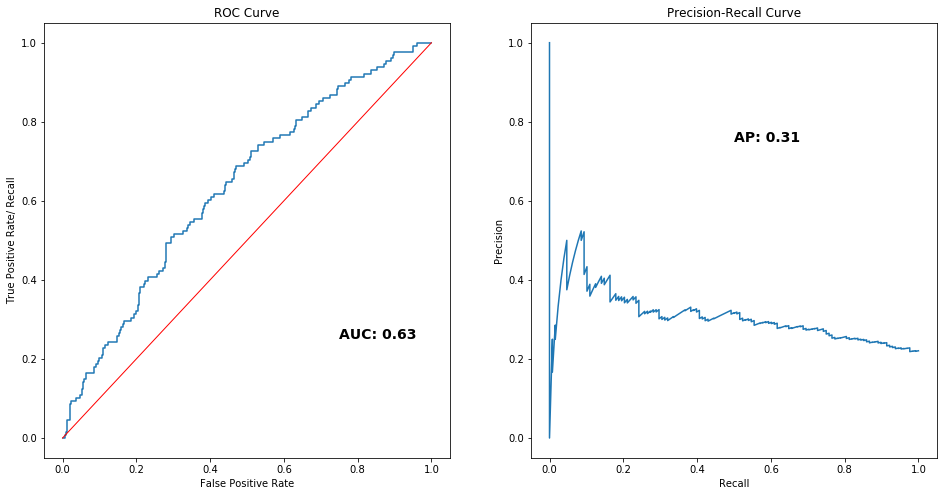

In [24]:
plot_roc_and_prc(y_test, y_test_prob_best_model)